# Stock Price Prediction Monte-Carlo Simulation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

In [23]:
# Step 1: Download historical data
tickers = ['PG']
data = yf.download(tickers, start='2015-01-01', end='2025-01-01')['Close']

df = data.reset_index()
df = pd.DataFrame(df.values)
df.columns = [	'Date', 'PG' ]
# df = df.set_index('Date')

df['PG'] = pd.to_numeric(df['PG'])

[*********************100%***********************]  1 of 1 completed


In [24]:
def monte_carlo_simulation(data, days, iterations):
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    log_returns = np.log(data[1:] / data[:-1])
    mean = np.mean(log_returns)
    variance = np.var(log_returns)
    drift = mean - (0.5 * variance)
    daily_volatility = np.std(log_returns)

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]
    for t in range(days):
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))
        future_prices[t] = current_price * np.exp(shocks)
        current_price = future_prices[t]
    return future_prices

In [25]:
simulation_days = 364
mc_iterations = 1000
mc_prices = monte_carlo_simulation(df['PG'], simulation_days, mc_iterations)

Average future price after 364 days: $189.83
Date of simulation: 2025-12-30
Real price on 2015-01-29 00:00:00: $64.74
Price difference: $125.09
Price difference percentage: 193.21%
Model accuracy: -93.21%


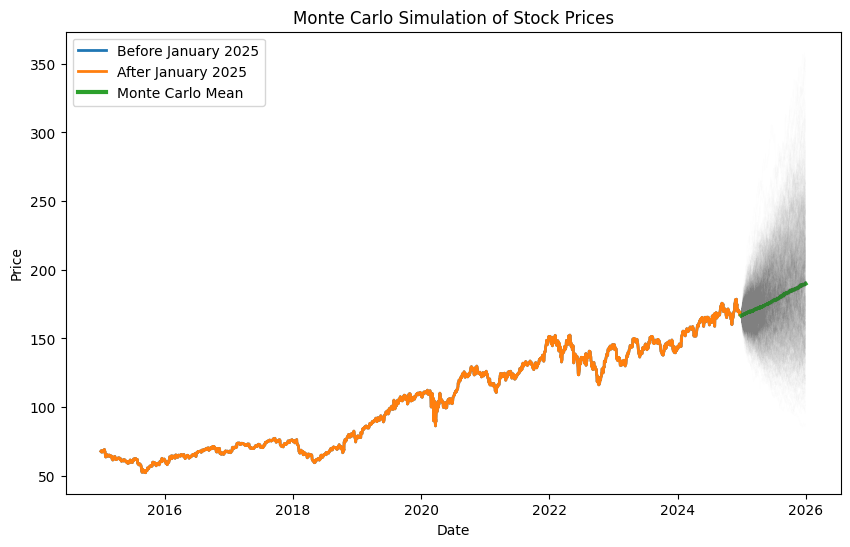

In [26]:
# Last closing price repeated for each iteration
last_close_price = np.full((1, mc_iterations), df['PG'].iloc[-1])

# Combine the last closing price with the Monte Carlo simulation prices
mc_prices_combined = np.concatenate((last_close_price, mc_prices), axis=0)

# Adjust the periods in the date range to match the number of rows in mc_prices_combined
last_date = df['Date'].iloc[-1]
simulated_dates = pd.date_range(start=last_date, periods=simulation_days + 1)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(pd.to_datetime(df['Date']), df['PG'], label='Before January 2025', linewidth=2)
plt.plot(pd.to_datetime(df['Date']), df['PG'], label='After January 2025', linewidth=2)

# Taking average of all simulations on the 365th day
future_price_mcmc = np.mean(mc_prices_combined[364, :])
print(f"Average future price after 364 days: ${future_price_mcmc:.2f}")
print(f"Date of simulation: {simulated_dates[364].date()}")
simulated_date = simulated_dates[364].date()
real_price = df['PG'][18]
real_date = df['Date'][18]
print(f"Real price on {real_date}: ${real_price:.2f}")
print(f"Price difference: ${future_price_mcmc - real_price:.2f}")
print(f"Price difference percentage: {(future_price_mcmc - real_price) / real_price * 100:.2f}%")
print(f"Model accuracy: {100 - abs((future_price_mcmc - real_price) / real_price * 100):.2f}%")

# Plot Monte Carlo simulations mean
plt.plot(simulated_dates, mc_prices_combined.mean(axis=1), label='Monte Carlo Mean', linewidth=3)

# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_prices_combined[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()